## Семинар 2 "Распознавание рукописных цифр"

ФИО: Мажаров Иван

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import *
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
%matplotlib inline

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [3]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

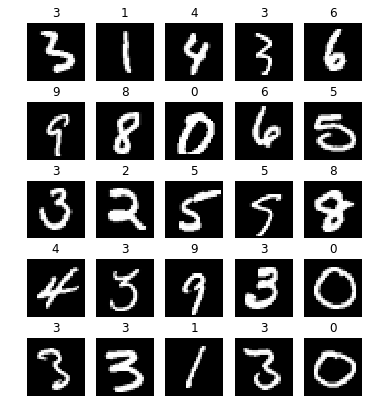

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [5]:
def train(network, epochs, learning_rate):
    loss = NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_epochs, label='Train')
    plt.plot(test_loss_epochs, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_epochs, label='Train accuracy')
    plt.plot(test_accuracy_epochs, label='Test accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

In [6]:
network = NeuralNetwork([Linear(784, 100), Sigmoid(),
               Linear(100, 100), Sigmoid(),
               Linear(100, 10)])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.305/0.298	Accuracy: 0.919/0.917

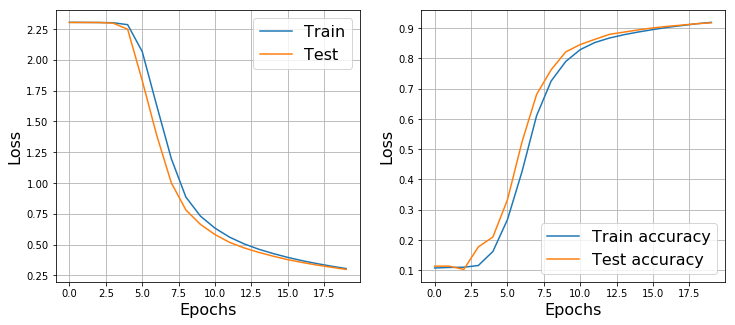

Wall time: 1min 47s


In [7]:
%time train(network, 20, 0.01)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [8]:
class ReLU:
    def __init__(self):
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.s = X * (X > 0)
        return self.s
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return 1. * (self.s > 0) * dLdy
    
    def step(self, learning_rate):
        pass

In [9]:
class ELU:
    def __init__(self, alpha):
        self.alpha = alpha
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.s = self.alpha * (np.exp(X) - 1) * (X < 0) + X * (X > 0)
        return self.s
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return self.alpha * np.exp(self.s) * (self.s < 0) * dLdy + 1. * (self.s > 0) * dLdy
    
    def step(self, learning_rate):
        pass

In [10]:
class LReLU:
    def __init__(self):
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.s = 0.01 * X * (X < 0) + X * (X > 0)
        return self.s
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return 0.01 * (self.s < 0) * dLdy + 1. * (self.s > 0) * dLdy
    
    def step(self, learning_rate):
        pass

In [11]:
network_relu = NeuralNetwork([Linear(784, 100), ReLU(),
               Linear(100, 100), ReLU(),
               Linear(100, 10)])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.036/0.085	Accuracy: 0.990/0.973

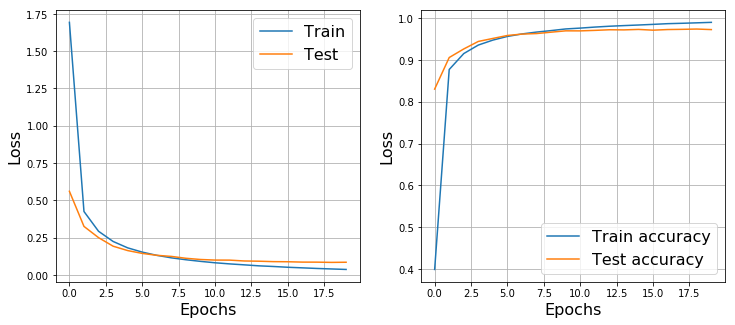

Wall time: 1min 44s


In [12]:
%time train(network_relu, 20, 0.01)

In [13]:
network_elu = NeuralNetwork([Linear(784, 100), ELU(1),
               Linear(100, 100), ELU(1),
               Linear(100, 10)])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.057/0.086	Accuracy: 0.983/0.973

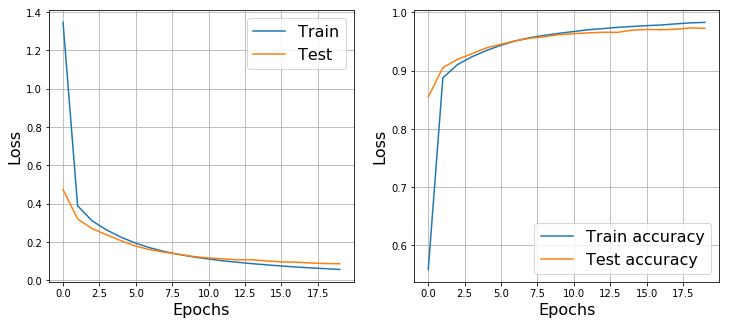

Wall time: 1min 58s


In [14]:
%time train(network_elu, 20, 0.01)

In [15]:
network_lrelu = NeuralNetwork([Linear(784, 100), LReLU(),
               Linear(100, 100), LReLU(),
               Linear(100, 10)])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.035/0.078	Accuracy: 0.991/0.977

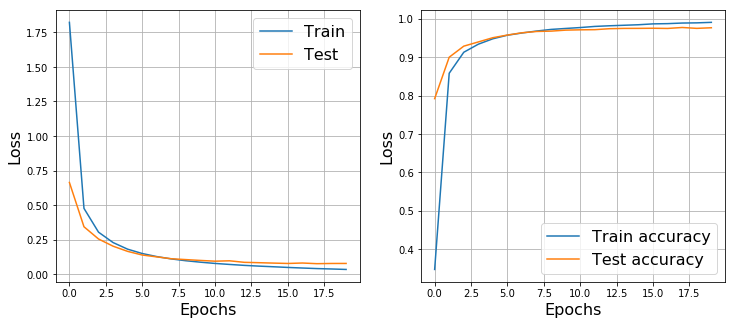

Wall time: 1min 49s


In [16]:
%time train(network_lrelu, 20, 0.01)

### Часть 3: Анализ ошибок

In [17]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[y[i]]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

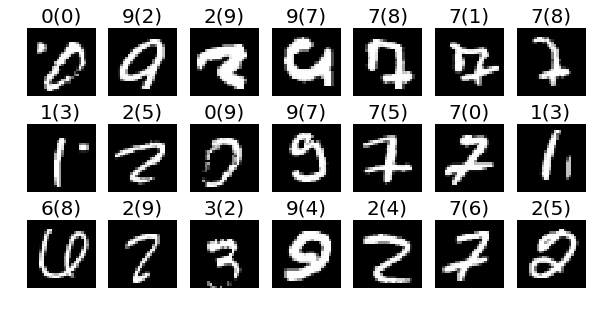

In [18]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### Часть 4: Улучшение результатов

In [19]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
rotate = transforms.Compose([
                       transforms.RandomRotation(15),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
train_dataset_rot = MNIST('.', train=True, download=True, transform=rotate)
concat_train = ConcatDataset((train_dataset,train_dataset_rot))

test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(concat_train, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [21]:
network_relu = NeuralNetwork([Linear(784, 512), ReLU(),
               Linear(512, 10)
                             ])
loss = NLLLoss()

Epoch 39... (Train/Test) NLL: 0.026/0.047	Accuracy: 0.994/0.985

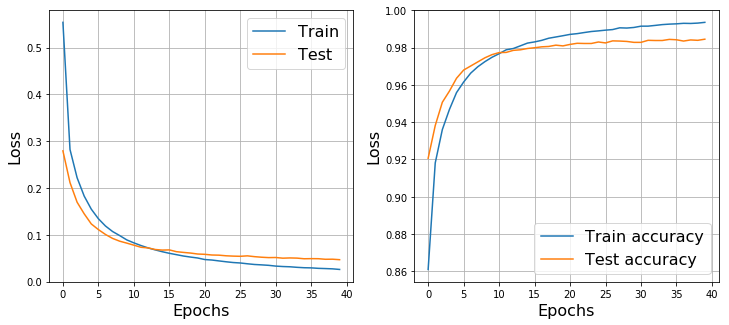

Wall time: 17min 59s


In [26]:
%time train(network_relu, 40, 0.005)

In [23]:
network_relu = NeuralNetwork([Linear(784, 512), LReLU(),
               Linear(512, 10)
                             ])
loss = NLLLoss()

Epoch 39... (Train/Test) NLL: 0.012/0.055	Accuracy: 0.997/0.985

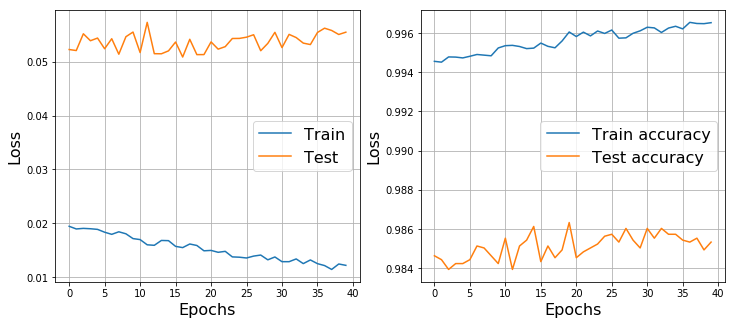

Wall time: 7min 30s


In [27]:
%time train(network_lrelu, 40, 0.005)

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

ReLU, ELU, LReLU увеличивают скорость сходимости и финальную точность в сравнении с сигмойдой

Аугментация (поворот) так же увеличивает точность. Возможно, результаты были бы еще лучше, если пофорот делать не средствами pytorch (после поворота качество картинок существенно снижается)

Была достигнута точность 0.986 на 40-ка итерациях.